In [1]:
from google.colab import drive
drive.mount('/content/drive') #shift + Enter

Mounted at /content/drive


In [2]:
import os
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, Input, Activation, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
root_path=r'/content/drive/MyDrive/dataset/fer'
emotions = os.listdir(root_path)

In [4]:
import cv2

In [5]:
happy_items=os.listdir(os.path.join(root_path, 'happy'))
len(happy_items)

1264

In [6]:
emotions = sorted(emotions)
emotions

['happy', 'sad']

In [7]:
from keras.utils import to_categorical
import numpy as np

In [8]:
train_x = []
train_y = []

for emotion in emotions:
  full_path = os.path.join(root_path,emotion)
  imgs = os.listdir(full_path)
  for img in imgs:
    img_path = os.path.join(full_path, img)
    vector_img = image.load_img(img_path, target_size=(224,224))
    vector_img = image.img_to_array(vector_img)
    vector_img = preprocess_input(vector_img)
    train_x.append(vector_img)
    train_y.append(emotions.index(emotion))

train_x = np.asarray(train_x)
train_y = to_categorical(train_y)

In [9]:
train_x.shape, train_y.shape

((2511, 224, 224, 3), (2511, 2))

In [10]:
from keras.models import Model
from sklearn.model_selection import train_test_split

In [11]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=7)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=7)

In [12]:
train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape

((1606, 224, 224, 3),
 (402, 224, 224, 3),
 (503, 224, 224, 3),
 (1606, 2),
 (402, 2),
 (503, 2))

In [13]:

base_model=ResNet50(input_shape=(224,224,3))
#base_model.summary()

102967424/102967424 [==============================] - 0s 0us/step


In [14]:
for layer in base_model.layers:
    layer.trainable=False
x=base_model.get_layer('avg_pool').output
x=Dense(2)(x)
# x=Activation('softmax')(x)
for layer in base_model.layers[-26:]:
    layer.trainable = True

saved_model_name="{epoch:02d}-{val_loss:.2f}.ckpt"
save_dir=r'/content/drive/MyDrive/saved_models/' #directory to save to the model for each epoch.
model_save_path = os.path.join(save_dir, saved_model_name)
model_checkpoint_callback=ModelCheckpoint(filepath=model_save_path, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=False)
model = Model(inputs=base_model.inputs, outputs=x)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=10, batch_size=32, callbacks=[model_checkpoint_callback])

In [16]:
saved_model_path=r'/content/drive/MyDrive/saved_models/10-0.79.ckpt'
# model.load_weights(saved_model_path)
test_loss, test_acc = model.evaluate(test_x, test_y)

print('test acc:', test_acc)

16/16 [==============================] - 11s 189ms/step - loss: 4.9793 - accuracy: 0.5050
test acc: 0.5049701929092407


In [17]:
import matplotlib.pyplot as plt
pred_list=[]

for i in range(train_x.shape[0]):
  pred = model.predict(train_x[i].reshape(1, *train_x[i].shape), verbose=0)
  scalar_label=np.argmax(train_y[i])
  pred_list.append(pred[0])

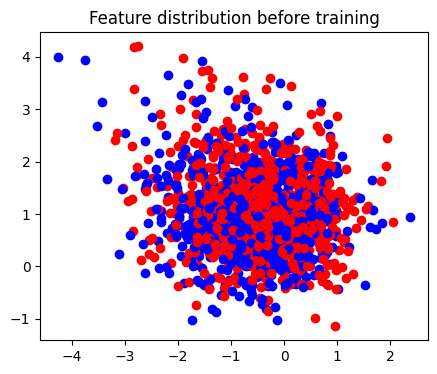

In [18]:
fig, ax =plt.subplots(figsize=(5,4))
label_colors={0:'b', 1: 'r'}
plt.title('Feature distribution before training')
for i in range(len(pred_list)):
  plt.scatter(pred_list[i][0], pred_list[i][1], c=label_colors[np.argmax(train_y[i])])